# K-nearest neighbors model (Модель К-ближайших соседей)
Импорт необходимых библиотек

In [2]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.stats import norm
from scipy.signal import welch, spectrogram
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")

# 1: Загрузка и подготовка данных

In [4]:
df = pd.read_csv('final_classification_dataset.csv')
df

,clean_signal,noise_signal,class,clean_signal_strength,noise_signal_strength,clean_interference_type,noise_interference_type
0,[ 0.53289387 0.48063746 0.42904256 0.378523...,[-0.08768768 -0.06199073 -0.03619172 -0.010593...,0,-28,-7,NaN,NaN
1,[ 0.50528564 0.46466091 0.42324726 0.381706...,[ 0.14792691 0.13895541 0.13001185 0.121231...,0,-55,-3,NaN,NaN
2,[-7.18195220e-01 -6.40748815e-01 -5.65319141e-...,[ 0.93549859 0.83830764 0.12244383 0.767919...,1,-8,-22,NaN,Adjacent-channel
3,[-0.96790673 -0.87108426 -0.77470803 -0.679792...,[ 0.50528564 0.46466091 0.42324726 0.381706...,0,-13,-55,NaN,NaN
4,[ 0.98972575 0.9192528 0.84971362 0.781599...,[-0.33507636 -0.88348707 -0.47259825 -0.746120...,1,-40,-99,NaN,Intermodulation
...,...,...,...,...,...,...,...
2851,[ 0.58609052 0.54398653 0.50094931 0.457321...,[-0.02181387 -0.04383759 -0.0630295 -0.079345...,0,-1,-25,NaN,NaN
2852,[ 0.74412673 0.68660089 0.62858591 0.570789...,[ 0.79502931 0.83269206 -0.1729633 -0.592429...,1,-47,-41,NaN,Adjacent-channel
2853,[ 0.08035012 0.07783327 0.07578205 0.074013...,[-0.35393032 0.05130525 -0.07953877 0.435607...,1,-58,-76,NaN,Intermodulation
2854,[ 3.63146618e-03 -8.63427338e-04 -6.42821694e-...,[-0.21247877 -0.93899 -0.92424433 -0.443822...,1,-53,-55,NaN,Co-channel


In [5]:
def safe_convert(signal):
    """Безопасное преобразование сигнала в массив numpy"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Стандартизация длины
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Преобразование сигнальных столбцов
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)


# 2: Улучшенный байесовский детектор сигналов

In [7]:
class BayesianSignalDetector:
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal
        
    def calculate_likelihood(self, x, hypothesis):
        if hypothesis == 'signal':
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)
    
    def detect_signal(self, observations):
        posteriors = []
        for x in observations:
            # Расчет правдоподобия
            l_signal = self.calculate_likelihood(x, 'signal')
            l_noise = self.calculate_likelihood(x, 'noise')
            
            # Расчет апостериорных вероятностей
            p_signal = l_signal * self.prior_signal
            p_noise = l_noise * self.prior_noise
            
            # Нормализация
            total = p_signal + p_noise
            posteriors.append((p_signal/total, p_noise/total))
        
        return np.array(posteriors)

class AdaptiveBayesianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_detectors=3):
        self.n_detectors = n_detectors
        self.detectors_ = []
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Требуется передача y при обучении")
            
        noise_signals = X.loc[y==0, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        signal_signals = X.loc[y==1, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        
        noise_params = self._estimate_parameters(noise_signals)
        signal_params = self._estimate_parameters(signal_signals)
        
        self.detectors_ = []
        for i in range(self.n_detectors):
            noise_std = noise_params[0] * (0.8 + i*0.2)
            signal_std = signal_params[1] * (0.7 + i*0.3)
            prior = 0.3 + i*0.2
            
            self.detectors_.append(
                BayesianSignalDetector(noise_std=noise_std, 
                                    signal_std=signal_std,
                                    prior_signal=prior)
            )
        return self
    
    def _estimate_parameters(self, signals):
        if isinstance(signals, pd.Series):
            values = np.concatenate([s.flatten() for s in signals])
        else:
            values = signals.flatten()
            
        std = np.std(values)
        return (std, std*0.7)
    
    def transform(self, X):
        features = []
        for i, detector in enumerate(self.detectors_):
            signals = X['noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
            
            detector_features = signals.apply(
                lambda x: self._extract_detector_features(x, detector, i))
            features.append(pd.DataFrame(detector_features.tolist()))
        
        return pd.concat(features, axis=1)
    
    def _extract_detector_features(self, signal, detector, detector_idx):
        posteriors = detector.detect_signal(signal)
        return {
            f'bayes_{detector_idx}_p_signal_mean': np.mean(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_std': np.std(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_max': np.max(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_min': np.min(posteriors[:, 0]),
            f'bayes_{detector_idx}_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
            f'bayes_{detector_idx}_signal_ratio': np.sum(posteriors[:, 0] > 0.5) / len(signal)
        }


In [8]:
def extract_time_domain_features(signal):
    """Новые признаки временной области"""
    diff_signal = np.diff(signal)
    return {
        'autocorr_peak': np.max(np.correlate(signal, signal)),
        'hjorth_mobility': np.sqrt(np.var(diff_signal) / np.var(signal)),
        'zero_crossing_rate': ((signal[:-1] * signal[1:]) < 0).mean(),
        'mean_abs_diff': np.mean(np.abs(diff_signal)),
        'signal_entropy': np.sum(-signal * np.log(signal + 1e-10))
    }

def extract_enhanced_features(signal, fs=1000):
    features = {}
    
    # Основная статистика
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2))
    })
    
    # Признаки временной области
    features.update(extract_time_domain_features(signal))
    
    # Частотная область
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_entropy', 'peak_frequency']})
    
    # Вейвлет-признаки
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
    except:
        pass
    
    return features

# 4: Пайплайн признаков

In [10]:
print("Извлечение признаков...")
clean_features = pd.DataFrame(df['clean_signal'].apply(extract_enhanced_features).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(extract_enhanced_features).tolist()).add_prefix('noise_')

# Байесовские признаки
bayes_df = df[['noise_signal']].copy()
bayes_df['class'] = df['class']
bayes_extractor = AdaptiveBayesianFeatures(n_detectors=3)
bayes_features = bayes_extractor.fit_transform(bayes_df.drop('class', axis=1), bayes_df['class'])

# Комбинация признаков
X = pd.concat([clean_features, noise_features, bayes_features,
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)


Извлечение признаков...


# 5: Пайплайн модели K-NN

In [12]:
pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    KNeighborsClassifier()
)

param_grid = {
    'selectkbest__k': [20, 30, 40],
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nОбучение модели K-NN...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)



Обучение модели K-NN...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Лучшие параметры: {'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform', 'selectkbest__k': 20}


# 6: Расширенная оценка модели


Отчет классификации:
                     precision    recall  f1-score   support

        Нет сигнала       0.77      0.94      0.84      1428
Сигнал присутствует       0.92      0.72      0.81      1428

           accuracy                           0.83      2856
          macro avg       0.84      0.83      0.83      2856
       weighted avg       0.84      0.83      0.83      2856



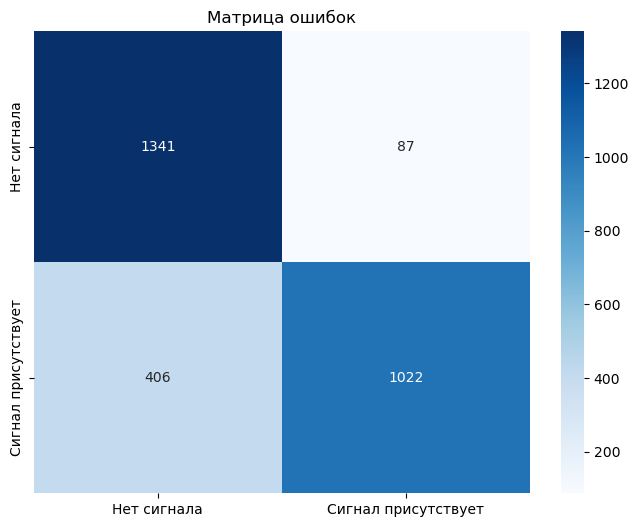

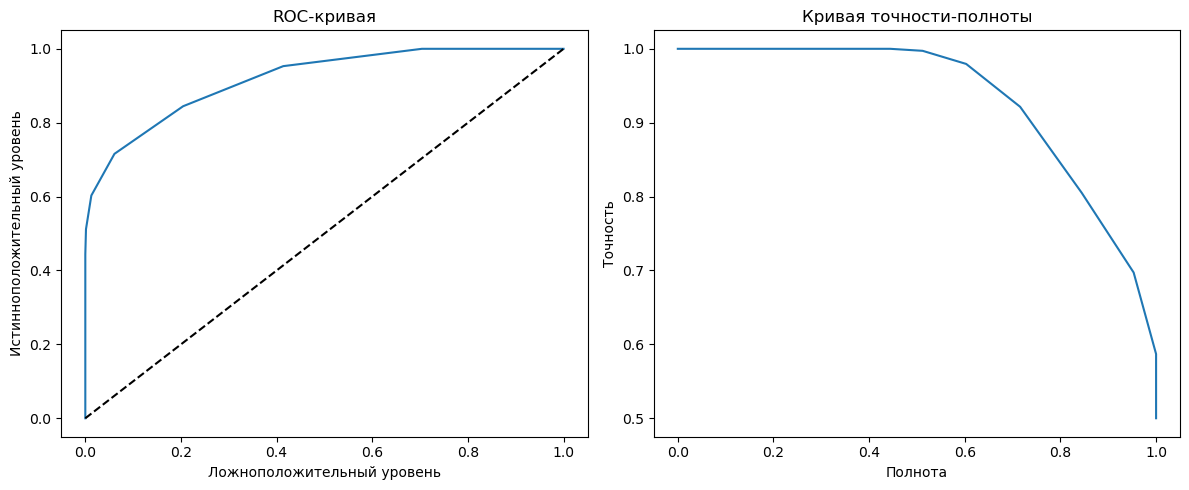

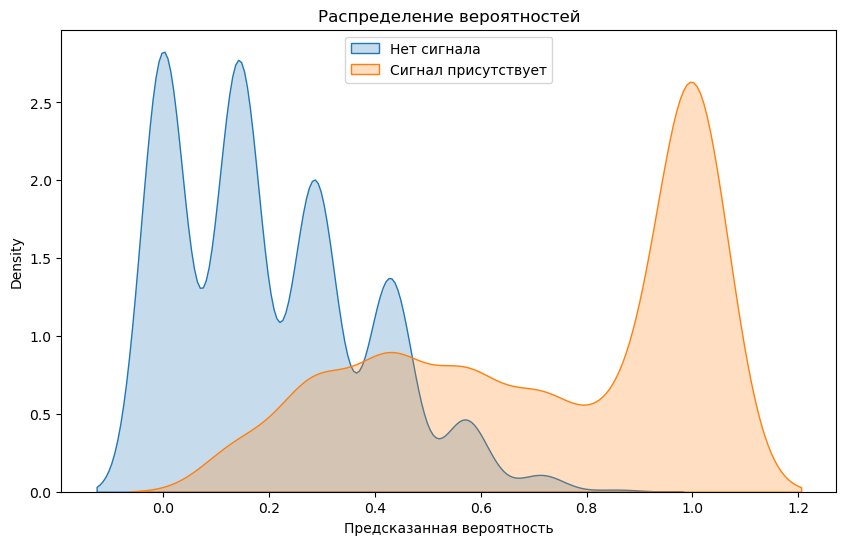

In [14]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print("\nОтчет классификации:")
    print(classification_report(y, y_pred, target_names=['Нет сигнала', 'Сигнал присутствует']))
    
    # Матрица ошибок
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Нет сигнала', 'Сигнал присутствует'],
                yticklabels=['Нет сигнала', 'Сигнал присутствует'])
    plt.title('Матрица ошибок')
    plt.show()
    
    # ROC и PR кривые
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Ложноположительный уровень')
    plt.ylabel('Истинноположительный уровень')
    plt.title('ROC-кривая')
    
    precision, recall, _ = precision_recall_curve(y, y_proba)
    ap_score = average_precision_score(y, y_proba)
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
    plt.xlabel('Полнота')
    plt.ylabel('Точность')
    plt.title('Кривая точности-полноты')
    plt.tight_layout()
    plt.show()

    # Распределение вероятностей
    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_proba[y == 0], label='Нет сигнала', fill=True)
    sns.kdeplot(y_proba[y == 1], label='Сигнал присутствует', fill=True)
    plt.title('Распределение вероятностей')
    plt.xlabel('Предсказанная вероятность')
    plt.legend()
    plt.show()

evaluate_model(best_model, X, y)

 # 7: Визуализация сигналов

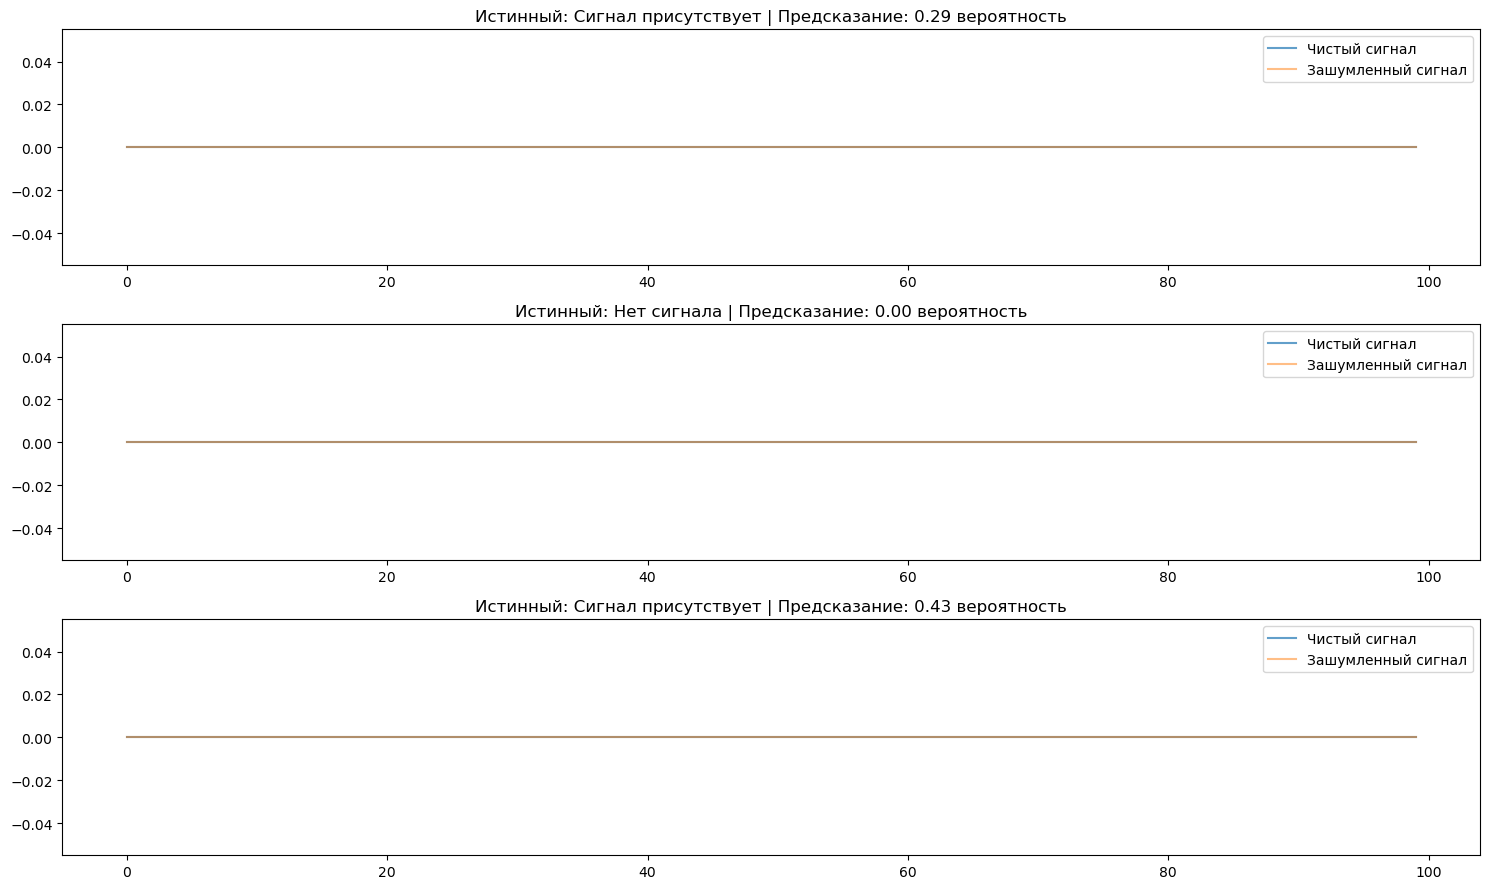


Обучение и оценка модели завершены!


In [16]:
def visualize_detection_samples(df, model, n=3):
    sample = df.sample(n)
    plt.figure(figsize=(15, 3*n))
    
    for i, (idx, row) in enumerate(sample.iterrows(), 1):
        plt.subplot(n, 1, i)
        
        # Визуализация сигналов
        plt.plot(row['clean_signal'], label='Чистый сигнал', alpha=0.7)
        plt.plot(row['noise_signal'], label='Зашумленный сигнал', alpha=0.5)
        
        # Информация о предсказании
        proba = model.predict_proba(X.iloc[[idx]])[0][1]
        true_label = 'Сигнал присутствует' if row['class'] == 1 else 'Нет сигнала'
        plt.title(f"Истинный: {true_label} | Предсказание: {proba:.2f} вероятность")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_detection_samples(df, best_model)

print("\nОбучение и оценка модели завершены!")